<h1>Recruit Restaurant Visitor Forecasting</h1>

<h3>Description:</h3>
<p>Running a thriving local restaurant isn't always as charming as first impressions appear. There are often all sorts of unexpected troubles popping up that could hurt business.

One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members. This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

Recruit Holdings has unique access to key datasets that could make automated future customer prediction possible. Specifically, Recruit Holdings owns Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software).

In this competition, we were challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.
</p>

**Evaluation Metric :**

We are going to use RMSLE (Root Mean Square Logarthimic Error) as our Evaluation metric, beacuse:
1. It incurs a larger penalty for the underestimation of the Actual variable than the Overestimation.
2. In simple words, more penalty is incurred when the predicted Value is less than the Actual Value. On the other hand, Less penalty is incurred when the predicted value is more than the actual value.

Please, note that our solution is inspired from the following sources:
1. https://github.com/Arturus/kaggle-web-traffic
2. https://github.com/MaxHalford/kaggle-recruit-restaurant/blob/master/Solution.ipynb 
3. https://www.kaggle.com/pureheart/1st-place-lgb-model-public-0-470-private-0-502 
4. https://www.kaggle.com/plantsgo/solution-public-0-471-private-0-505 
5. https://www.kaggle.com/h4211819/holiday-trick https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/49100
6. https://csanjay.medium.com/recruit-restaurant-visitor-forecasting-a704cd5432c8
7. https://www.kaggle.com/asindico/a-japanese-journey
8. https://github.com/anki1909/Recruit-Restaurant-Visitor-Forecasting


Team Name of our Group: **UMN_MSBA_2022_KGF**

## Initialization

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, re
from sklearn import ensemble, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import time, datetime
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeRegressor
from scipy.sparse.linalg import svds
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input,LeakyReLU,Dense,BatchNormalization,Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import plotly.graph_objs as go
import plotly.offline as offline
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Set up Google Drive
from google.colab import files
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Set up root directory
input = '/content/drive/Shared drives/Predictive Final Project/data/input/'
output = '/content/drive/Shared drives/Predictive Final Project/data/output/'
weather = '/content/drive/Shared drives/Predictive Final Project/data/weather' 

### Read all the datasets


In [ ]:
air_visit_data = pd.read_csv('air_visit_data.csv')
air_store_info = pd.read_csv('air_store_info.csv')
air_reserve = pd.read_csv('air_reserve.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
date_info = pd.read_csv('date_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## Exploratory Data Analysis

### 1. Visitors vs Genre

Text(0.5, 1.0, 'Total visitors by Genre')

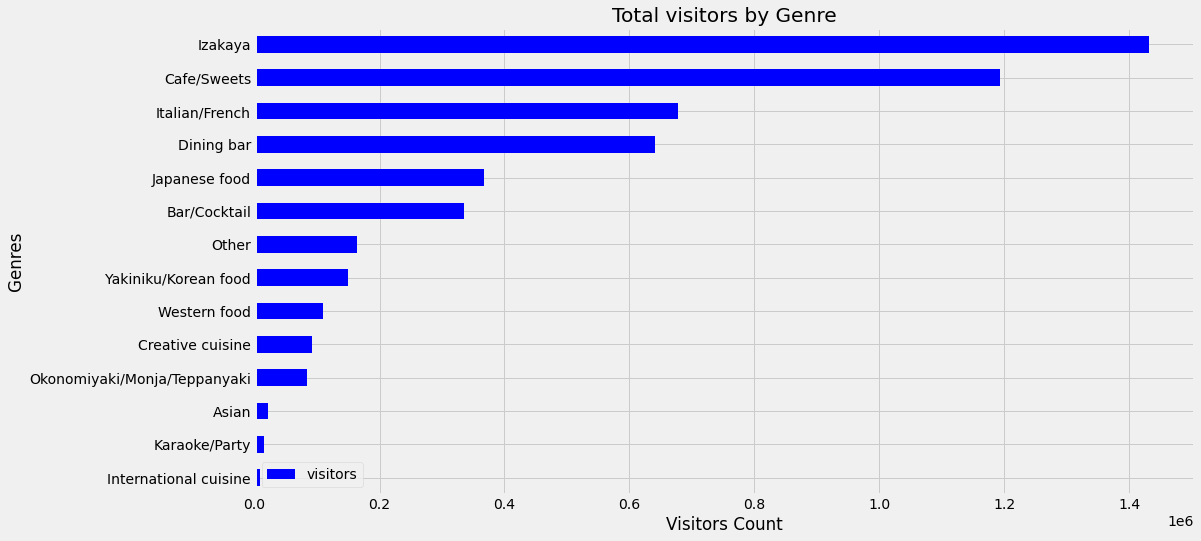

In [ ]:
genre = pd.DataFrame(air_visit_data.groupby(['air_genre_name'])['visitors'].sum())
genre.plot(kind='barh', color= 'blue', figsize=(15,8))
plt.title("Total visitors by Genre", loc='center')
plt.xlabel('Visitors Count')
plt.ylabel('Genres')
plt.show()

>**Observations:**
We can see that there around 14 genres of food serve by the restaturants.
The most popular genre is **Izakaya** followed by **Cafe/Sweets** which are liked by maximum number of people.
From the above graph we can say that genre is an important factor for predicting vsitors.

### 2. Yearly trend of Visitors by Day of week

Text(0.5, 1.0, 'Visitors by Day of Week ')

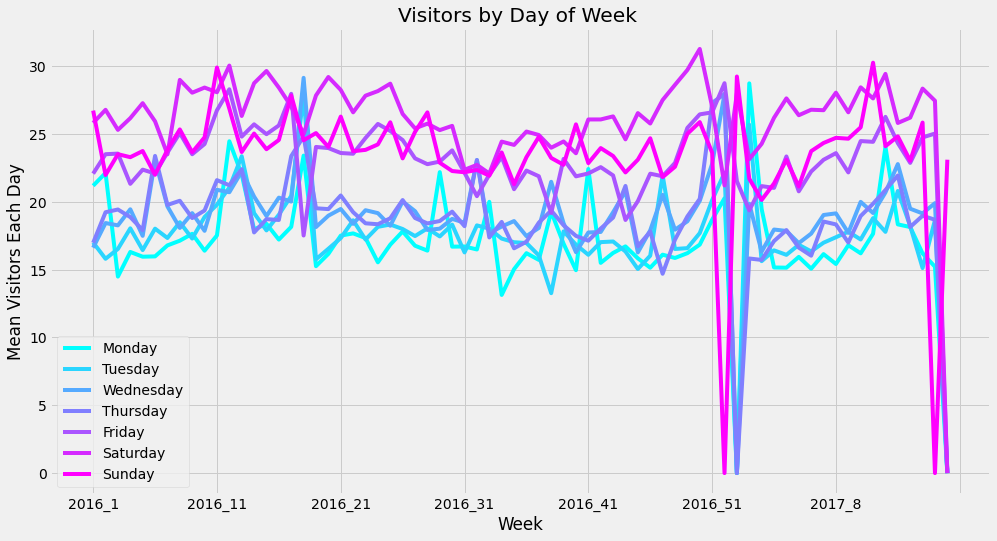

In [ ]:
dow = pd.DataFrame(pd.pivot_table(air_visit_data, index=['year','week'], columns='dow',values='visitors', aggfunc=[np.mean],fill_value=0).to_records())
dow.plot(kind='line', cmap='cool', figsize=(15,8))
plt.title("Visitors by Day of Week")
plt.xlabel("Week")
plt.ylabel("Mean Visitors Each Day")
plt.show()

>**Observations:**
>1. Saturdays and Sundays are the peak days for the restaurnats in a given week.
>2. The sharp decline after 51st week is due to the new year's eve

### 3. Average Visitors Each Month

Text(0.5, 1.0, 'Monthly Average Visitors')

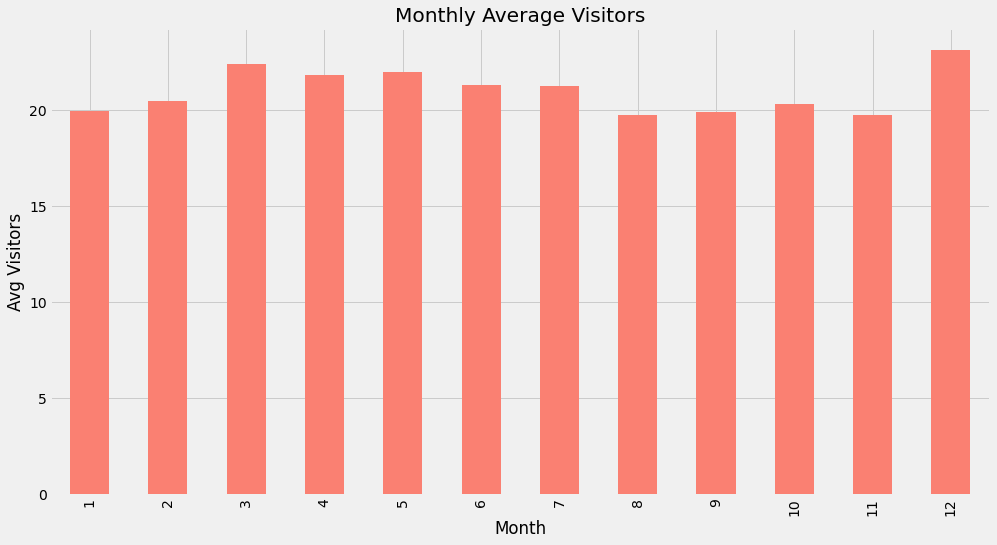

In [ ]:
avg_visitors_month = air_visit_data.groupby(['month'])['visitors'].mean()
avg_visitors_month.plot(kind='bar', figsize=(15,8))
plt.title('Monthly Average Visitors')
plt.xlabel('Month')
plt.ylabel('Average Visitors')
plt.show()

>**Observations:**
In the whole year, restaurants expect highest footfall of visitors during the month of December and then may which are the festive months.

### 4. Average Visitors Each Day Of Month

Text(0.5, 1.0, 'Average Visitors Each Day Of Month')

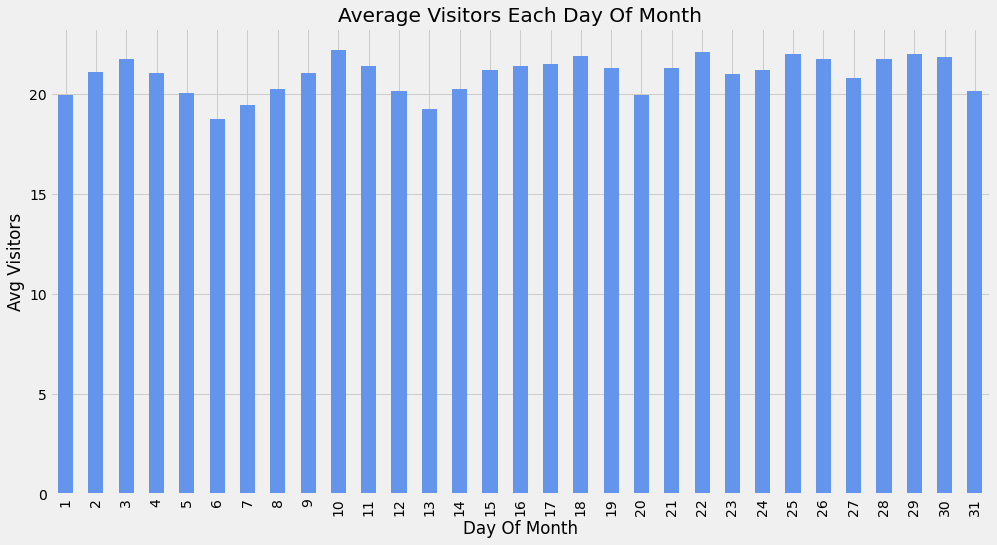

In [ ]:
avg_visitors_dom = air_visit_data.groupby(['day'])['visitors'].mean()
avg_visitors_dom.plot(kind='bar', figsize=(15,8))
plt.title('Average Visitors Each Day Of Month')
plt.xlabel('Day Of Month')
plt.ylabel('Avg Visitors')
plt.show()

>**Observations:**.
The average vistors are hisghest at the end of month, may be the credit of salaries at the end of the month be the reason behind that hike.

### 5. Average Visitors Each Day Of Week

Text(0.5, 1.0, 'Average Visitors Each Day Of Week')

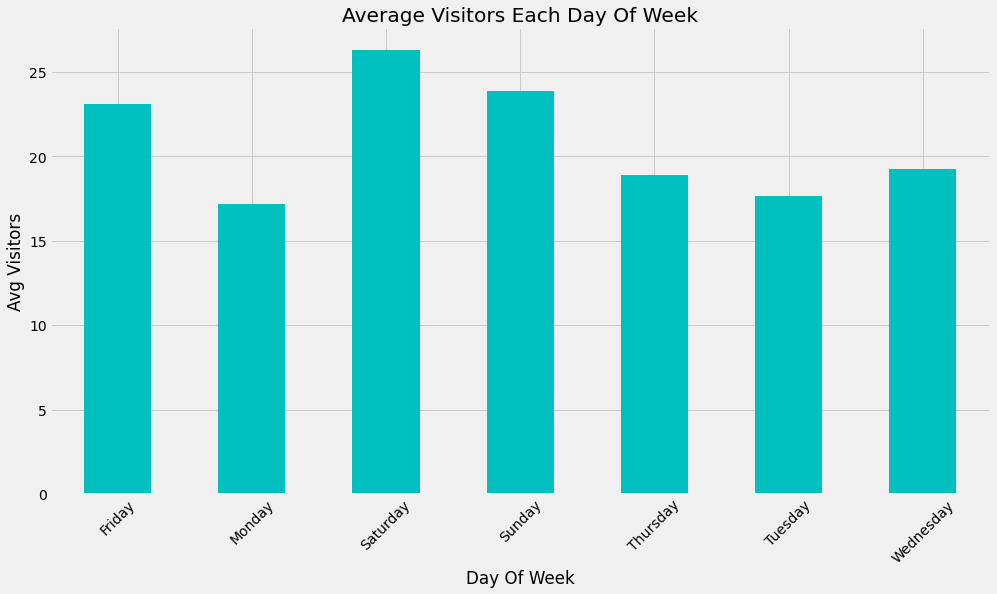

In [ ]:
avg_visitors_week = air_visit_data.groupby(['day_of_week'])['visitors'].mean().to_frame()
avg_visitors_week.plot(kind='bar', figsize=(15,8))
plt.title('Average Visitors Each Day Of Week')
plt.xlabel('Day Of Week')
plt.ylabel('Avg Visitors')
plt.show()

>**Observations:**
From the above graph, we can see that most people often vist on saturday and restaurant see the least footall during Monday and Tuesday.

### 6. Holidays vs Non-Holidays

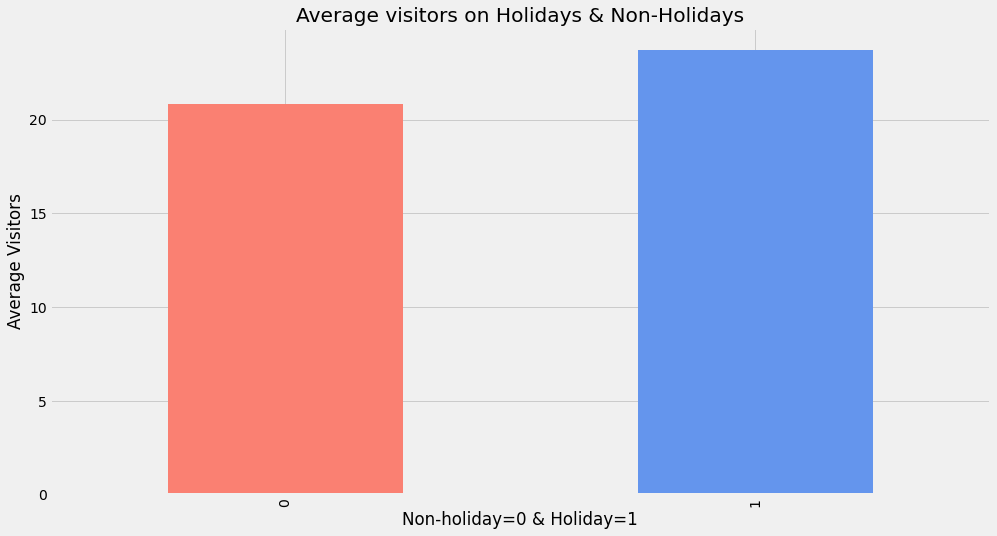

In [ ]:
holiday = air_visit_data[['holiday_flg','visitors']].groupby(['holiday_flg'])['visitors'].mean()
holiday.plot(kind='bar',figsize=(15,8))
plt.title('Average visitors Holidays & Non-Holidays')
plt.xlabel('Holidays vd Non-Holidays')
plt.ylabel('Average Visitors')
plt.show()

>**Observation:**
Form the above plot we can see that the difference between the visitors on holidays and working days is not significantly large but still can be inferred that people often like to visit restaurants during holidays.Hence, weekend and holiday are considered as important factors in predicting visitors.

### 7. Hourly Visitors Behaviour

In [ ]:
air_reserve_data = pd.merge(air_reserve,air_store_info,how='left', on=['air_store_id'])
hpg_reserve_data = pd.merge(hpg_reserve,store_id_relation,on=['hpg_store_id'],how='inner')

air_reserve_visitors = air_reserve_data.groupby(['visit_hour'])['air_reserve_visitors'].count()
hpg_reserve_visitors = hpg_reserve_data.groupby(['visit_hour'])['hpg_reserve_visitors'].count()

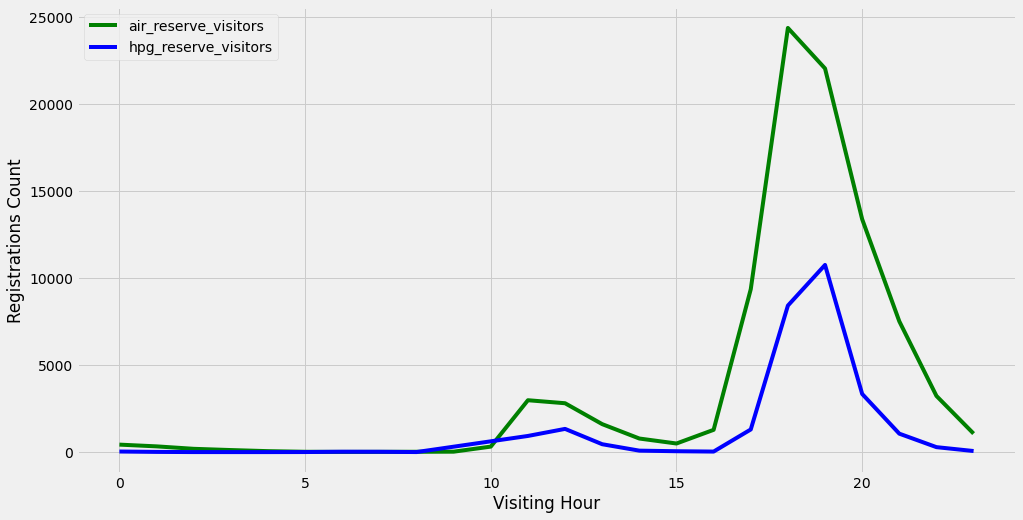

In [ ]:
air_reserve_visitors.plot(kind='line',color= 'd')
hpg_reserve_visitors.plot(kind='line',color= 'c')

plt.title('Hourly Registrations')
plt.xlabel('Visiting Hour')
plt.ylabel('Registrations Count')
plt.show()

### Observations:-
As we can see that the peak hours of restaurants is between 5:30 PM to 7:00 PM (approx).

### 8. Reversations Analysis

In [ ]:
total_air_reserve = air_reserve_data.groupby(['air_store_id','visit_date'],as_index=False)['air_reserve_visitors'].sum()
total_hpg_reserve =  hpg_reserve_data.groupby(['air_store_id','visit_date'],as_index=False)['hpg_reserve_visitors'].sum()

air_reserve_visitors = total_air_reserve.groupby(['air_store_id'],as_index=False)['air_reserve_visitors'].mean()
hpg_reserve_visitors = total_hpg_reserve.groupby(['air_store_id'],as_index=False)['hpg_reserve_visitors'].mean()

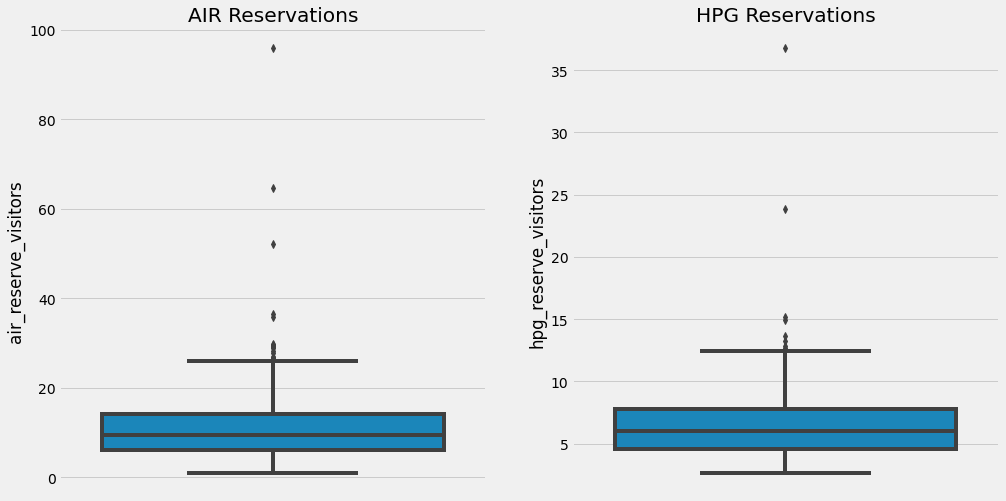

In [ ]:
f, ax = plt.subplots(1,2, figsize=(15,8))

sns.boxplot(y='air_reserve_visitors', data=air_reserve_visitors, ax=ax[0])
sns.boxplot(y='hpg_reserve_visitors', data=hpg_reserve_visitors, ax=ax[1])

ax[0].set_title('AIR Reservations')
ax[1].set_title('HPG Reservations')
plt.show()

### 9. Reservations vs Genres

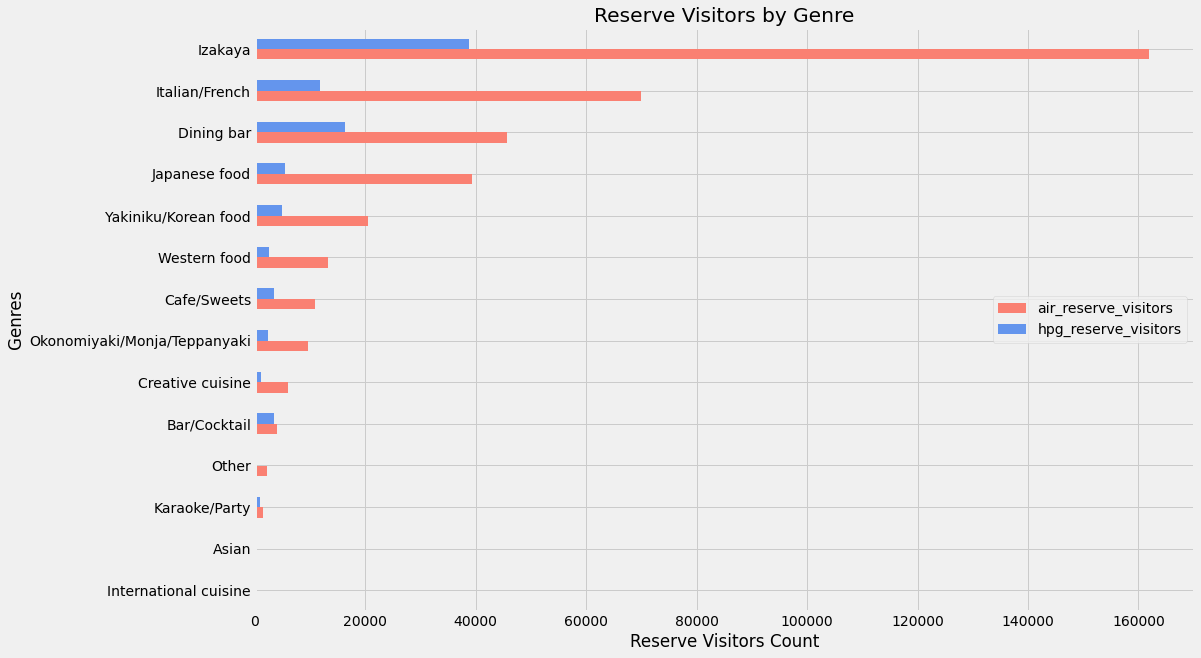

In [ ]:
genre = air_visit_data.groupby(['air_genre_name'])['air_reserve_visitors','hpg_reserve_visitors'].sum()
genre.plot(kind='barh', figsize=(15,8))
plt.title("Reserve Visitors by Genre")
plt.xlabel('Reserve Visitors Count')
plt.ylabel('Genres')
plt.show()

>**Observation:**
The trend for reservations is kind of similar to that of visitors trend. Like visitors trends, Izakaya is the most popular genre among reservations.

### 10. Visitors vs Reservations

Text(0.5, 0, 'Visit Date')

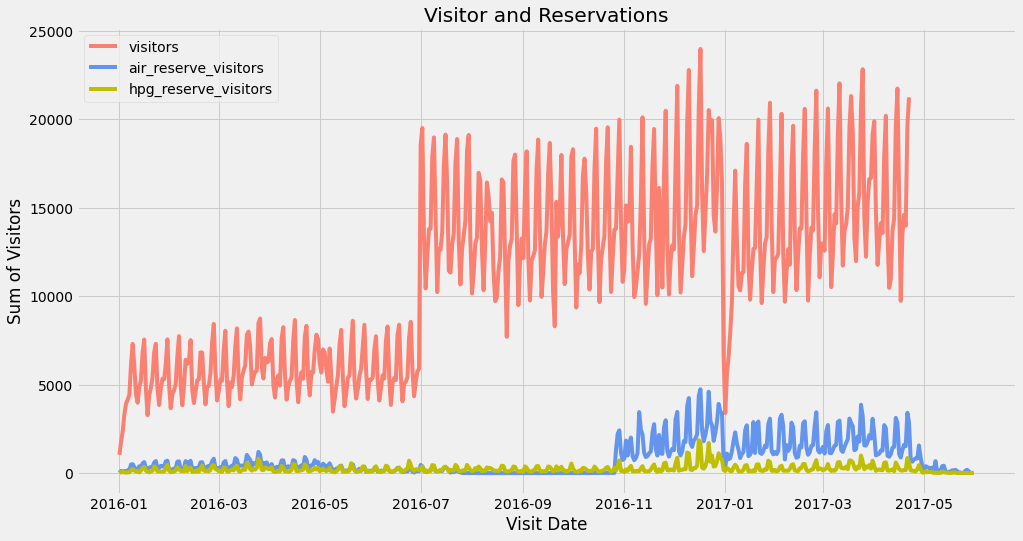

In [ ]:
df1 = air_visit_data.groupby(['visit_date'])['visitors'].sum()
df1.plot(color='r', kind='line')

df2 = air_reserve_data.groupby(['visit_date'])['air_reserve_visitors'].sum()
df2.plot(color='g', kind='line')

df3 = hpg_reserve_data.groupby(['visit_date'])['hpg_reserve_visitors'].sum()
df3.plot(color='y', kind='line', ax=ax)

plt.title("Visitor vs Reservations")
plt.xlabel("Date of Visit")
plt.ylabel("Total Visitors")
plt.show()

>**Observations:**
From the above graph, The reservations and visitors follow similar trend. Hence, reseravtions plays a vital role in predicting visitors.

### 11. Resturant Market Share Genre Wise

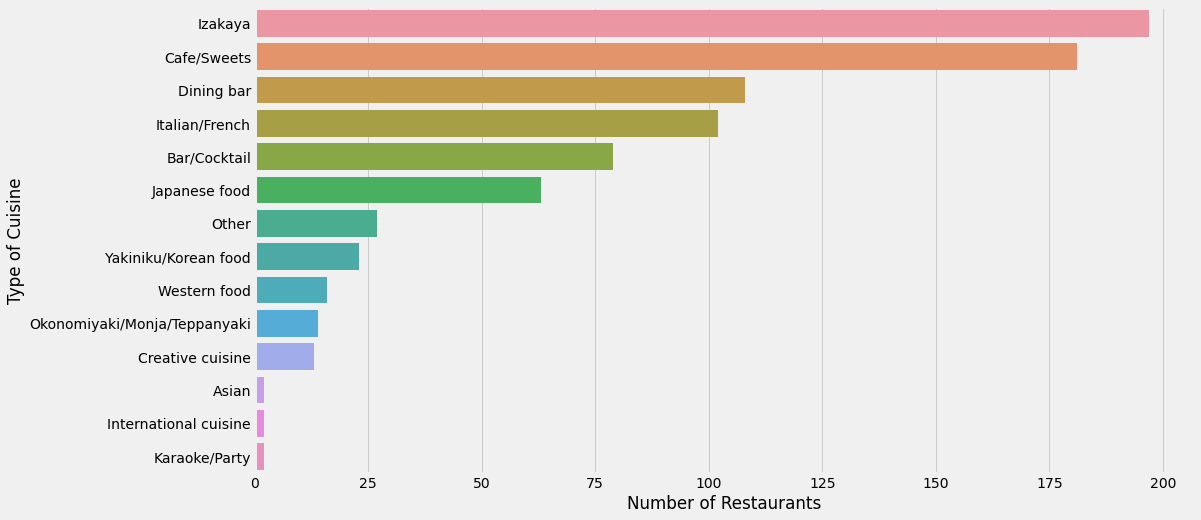

In [ ]:
air_store_genre = air_store_info.groupby(air_store_info['air_genre_name'])['air_store_id'].count()
sns.barplot(x='air_store_id', y='air_genre_name', data=air_store_genre, figsize=(15, 8))
plt.xlabel("Total Number of Restaurants")
plt.ylabel("Cuisines")
plt.show()

>**Observations:**
From the above graph, **Izakaya** is the most popular genre in Japan. 

## Data Cleaning

### Handling Outliers

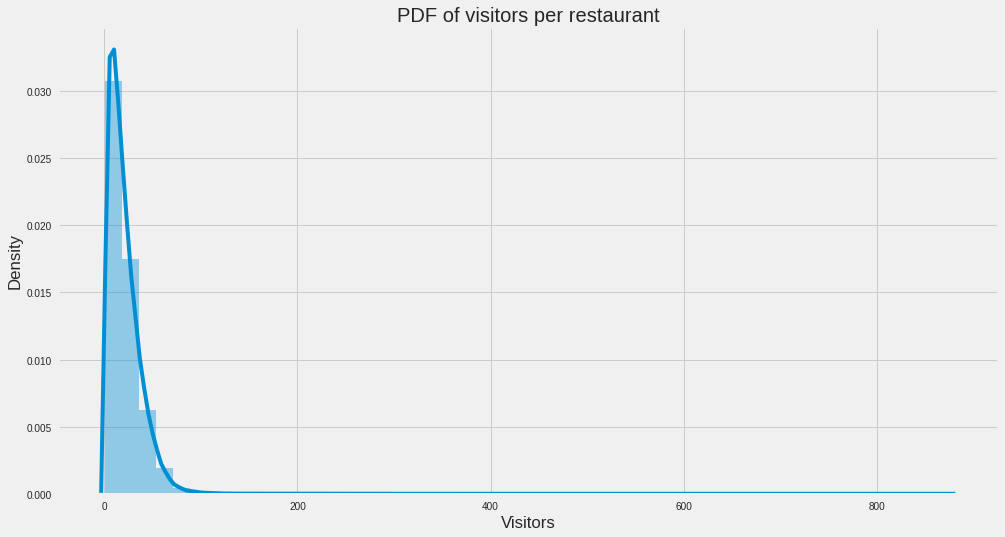

In [ ]:
visitors = air_data['visitors'].to_frame()

f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a=visitors.values, ax=ax)
plt.xlabel('Visitors')
plt.ylabel('Density')
plt.title('Distribution of Visitors')
plt.show()

In [ ]:
visitors.describe()

,visitors
count,252108.000000
mean,20.973761
std,16.757007
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,877.000000


>**Observations:**
>1. The Distribution of Visitors (Target Variable) is  highly left skewed with mean visitors 20.97 and and the max visitors reaching around 877, indicating outliers which need to be removed.

We simply define outliers using the following rules:

* Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile

* Data point that falls outside of 3 standard deviations. 

So we only need to:
*   Arrange the data in increasing order
*   Calculate first(q1) and third quartile(q3)
*   Find interquartile range (q3 - q1)
*   Find lower bound q1*1.5
*   Find upper bound q3*1.5

In [ ]:
visitors = visitors.sort_values(by = 'visitors')
q1, q3 = np.percentile(visitors.visitors,[25,75])
iqr = q3 - q1
lower_bound = q1 -(2 * iqr) 
upper_bound = q3 +(2 * iqr)
print('The lower bound of visitors is {:.2f}'.format(lower_bound))
print('The upper bound of visitors is {:.2f}'.format(upper_bound))

The lower bound of visitors is -31.00
The upper bound of visitors is 69.00


The min number of visitors should be 0 under the context. So we don't need to deal with values that are less than 0. And we use the upper bound value to substitude the outliers rather than remove them.

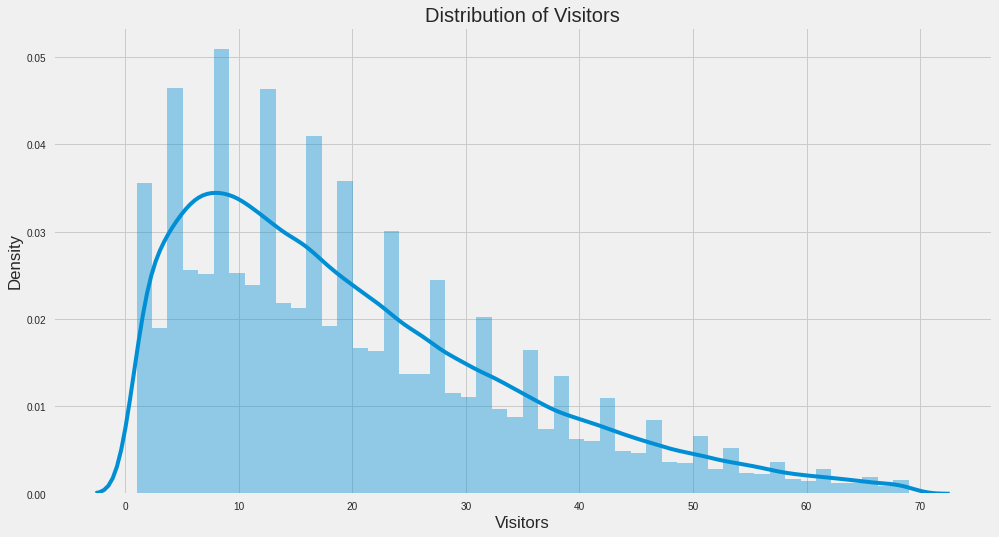

In [ ]:
  visitors.loc[visitors.visitors > upper_bound ,'visitors'] = -1
  visitors = visitors[visitors['visitors'] >= 0]

  f,ax = plt.subplots(1,1, figsize=(15,8))
  sns.distplot(a=visitors.values, ax=ax)
  plt.xlabel('Visitors')
  plt.ylabel('Density')
  plt.title('Distribution of Visitors')
  plt.show()

# Feature Engineering 

### Split Training and Testing Dataset

In [ ]:
# Test
test = sample_submission.copy()
test['air_store_id'] = test['id'].apply(lambda x: str(x)[:-11])
test['visit_date'] = test['id'].apply(lambda x: str(x)[-10:])
test = test.drop(['id', 'visitors'], axis = 1)

# Train
train = air_visit_data.copy()

### 1. Time Series Features

#### 1.1. Visit Date Statistics (Month, Year, Day of Week & Week of year)

In [ ]:
air_visit_data['visit_date_month'] = air_visit_data.visit_date.dt.month
air_visit_data['visit_date_dayofw'] = air_visit_data.visit_date.dt.dayofweek
air_visit_data['visit_date_year'] = air_visit_data.visit_date.dt.year
air_visit_data['weekofyear'] = air_visit_data.visit_date.dt.weekofyear
air_visit_data.loc[air_visit_data.weekofyear==53, 'weekofyear'] = 0 
air_visit_data.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,holiday_eve,non_working,genre_in_area,...,visitors_min,visit_date_month,visit_date_dayofw,visit_date_year,visit_date_dayofm,weekofyear,reserve_datetime,reserve_visitorslist,total_reserve,numb_total_reserve
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,1.098612,1,2,2016,13,2,NaN,NaN,-1,0
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,1.098612,1,3,2016,14,2,NaN,NaN,-1,0
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,1.098612,1,4,2016,15,2,NaN,NaN,-1,0
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,1,8,...,0.693147,1,5,2016,16,2,NaN,NaN,-1,0
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,1.098612,1,0,2016,18,3,NaN,NaN,-1,0


In [ ]:
sample_submission['visit_date_month'] = sample_submission.visit_date.dt.month
sample_submission['visit_date_dayofw'] = sample_submission.visit_date.dt.dayofweek
sample_submission['visit_date_year'] = sample_submission.visit_date.dt.year
sample_submission['weekofyear'] = sample_submission.visit_date.dt.weekofyear
sample_submission.loc[sample_submission.weekofyear==53, 'weekofyear'] = 0 
sample_submission.head()

,id,visitors,air_store_id,visit_date,air_genre_name,air_area_name,latitude,longitude,holiday_eve,non_working,...,visitors_min,visit_date_month,visit_date_dayofw,visit_date_year,visit_date_dayofm,weekofyear,reserve_datetime,reserve_visitorslist,total_reserve,numb_total_reserve
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,1,...,1.098612,4,6,2017,23,16,NaN,NaN,-1,0
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,...,0.693147,4,0,2017,24,17,NaN,NaN,-1,0
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,...,0.693147,4,1,2017,25,17,NaN,NaN,-1,0
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,...,0.693147,4,2,2017,26,17,NaN,NaN,-1,0
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,...,0.693147,4,3,2017,27,17,NaN,NaN,-1,0


#### 1.2. Holiday Features

In [ ]:
# Comvert calendar_date to date field
date_info['calendar_date']  = pd.to_datetime(date_info['calendar_date'],format= '%Y-%m-%d')
date_info.rename(columns = {'calendar_date':'visit_date'},inplace = True)

# Get weekend and holidays
wkend_holidays = date_info.apply((lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1.0) / len(date_info)) ** 5.0

# Merge tran & test
train = train.merge(date_info,on='visit_date',how='left')
test = test.merge(date_info,on='visit_date',how='left')

# Separate Working and Non working days
date_info_mod = date_info.copy()
date_info_mod['holiday_eve'] = np.zeros(date_info_mod.shape[0])
date_info_mod['holiday_eve'].iloc[:-1] = date_info_mod['holiday_flg'].copy().values[1:]
date_info_mod['non_working'] = np.where(date_info_mod['day_of_week'].isin(['Saturday', 'Sunday']) |
                                        date_info_mod['holiday_flg'] == 1, 1, 0)
date_info_mod = date_info_mod.drop('holiday_flg', axis = 1)
date_info_mod.head()

,visit_date,day_of_week,weight,holiday_eve,non_working
0,2016-01-01,Friday,2.707368e-14,0.0,1
1,2016-01-02,Saturday,8.663577e-13,0.0,1
2,2016-01-03,Sunday,6.578904e-12,0.0,1
3,2016-01-04,Monday,2.772345e-11,0.0,0
4,2016-01-05,Tuesday,8.460525e-11,0.0,0


#### 1.3. Previous & Next Day Holidays

In [ ]:
# Rename columns
date_info.rename(columns={'holiday_flg': 'is_holiday', 'calendar_date': 'visit_date'}, inplace=True)

# Prev days holiday flag
# 1 means holiday, 0 means not
date_info['prev_day'] = date_info['is_holiday'].shift().fillna(0)

# Following days holiday flag
# 1 means holiday, 0 means not
date_info['next_day'] = date_info['is_holiday'].shift(-1).fillna(0)
date_info.head()

,visit_date,day_of_week,is_holiday,weight,prev_day,next_day
0,2016-01-01,Friday,1,2.707368e-14,0.0,0.0
1,2016-01-02,Saturday,0,8.663577e-13,1.0,0.0
2,2016-01-03,Sunday,0,6.578904e-12,0.0,0.0
3,2016-01-04,Monday,0,2.772345e-11,0.0,0.0
4,2016-01-05,Tuesday,0,8.460525e-11,0.0,0.0


#### 1.4. Season Labels

In [ ]:
def seasonLabel(row):
    if row['month'] in [3,4,5]:
        return 'spring'
    if row['month'] in [6,7,8]:
        return 'summer'
    if row['month'] in [9,10,11]:
        return 'autumn'
    if row['month'] in [12,1,2]:
        return 'winter'

air_visit_data["visit_date"] = pd.to_datetime(air_visit_data["visit_date"])
air_visit_data["month"] = air_visit_data["visit_date"].dt.month
air_visit_data["week"] = air_visit_data["visit_date"].dt.week
air_visit_data["dayofweek"] = air_visit_data["visit_date"].dt.dayofweek   
air_visit_data["season"] = air_visit_data.apply(lambda row:seasonLabel(row), axis=1)  
air_visit_data.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,holiday_eve,non_working,genre_in_area,...,visit_date_dayofm,weekofyear,reserve_datetime,reserve_visitorslist,total_reserve,numb_total_reserve,month,week,dayofweek,season
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,13,2,NaN,NaN,-1,0,1,2,2,winter
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,14,2,NaN,NaN,-1,0,1,2,3,winter
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,15,2,NaN,NaN,-1,0,1,2,4,winter
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,1,8,...,16,2,NaN,NaN,-1,0,1,2,5,winter
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,18,3,NaN,NaN,-1,0,1,3,0,winter


#### 1.5. Prior Year Mapping

In [ ]:
# Map prev year to current year
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
air_visit_data['prev_visitors'] = air_visit_data.groupby([air_visit_data['visit_date'].dt.week, air_visit_data['visit_date'].dt.weekday])['visitors'].shift()
air_visit_data.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,holiday_eve,non_working,genre_in_area,...,weekofyear,reserve_datetime,reserve_visitorslist,total_reserve,numb_total_reserve,month,week,dayofweek,season,prev_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,2,NaN,NaN,-1,0,1,2,2,winter,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,2,NaN,NaN,-1,0,1,2,3,winter,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,2,NaN,NaN,-1,0,1,2,4,winter,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,1,8,...,2,NaN,NaN,-1,0,1,2,5,winter,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,3,NaN,NaN,-1,0,1,3,0,winter,NaN


### 2. Visitors Features

In [ ]:
def visitor_features_week(df, visitor_data):
    tmp1 = visitor_data.groupby(['air_store_id', 'dow'])['visitors'].min().rename(columns={'visitors': 'min_visitors'})
    tmp2 = visitor_data.groupby(['air_store_id', 'dow'])['visitors'].max().rename(columns={'visitors': 'max_visitors'})
    tmp3 = visitor_data.groupby(['air_store_id', 'dow'])['visitors'].mean().rename(columns={'visitors': 'avg_visitors'})
    tmp4 = visitor_data.groupby(['air_store_id', 'dow'])['visitors'].count().rename(columns={'visitors': 'num_visitors'})

    df = pd.merge(df, tmp1, how='left', on=['air_store_id', 'dow']) 
    df = pd.merge(df, tmp2, how='left', on=['air_store_id', 'dow']) 
    df = pd.merge(df, tmp3, how='left', on=['air_store_id', 'dow']) 
    df = pd.merge(df, tmp4, how='left', on=['air_store_id', 'dow']) 
    
    return df

In [ ]:
date_info_mod['calendar_date'] = pd.to_datetime(date_info_mod['calendar_date'])
air_visit_wd = air_visit_data.join(date_info_mod.set_index('calendar_date'), on='visit_date')
air_visit_wd['visitors'] = air_visit_wd['visitors'].apply(lambda x: np.log1p(x)) 

train['month'] = train['visit_date'].apply(lambda x: float(str(x)[5:7]))
train = train.join(date_info_mod.set_index('calendar_date'), on='visit_date')
train = train.join(air_store_info.set_index('air_store_id'), on='air_store_id')

test['month'] = test['visit_date'].apply(lambda x: float(str(x)[5:7]))
test = test.join(date_info_mod.set_index('calendar_date'), on='visit_date')
test = test.join(air_store_info.set_index('air_store_id'), on='air_store_id')

In [ ]:
train['visit_date'] = pd.to_datetime(train['visit_date'])
train = visitor_features_week(train, air_visit_wd) 
train.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,holiday_eve,non_working,genre_in_area_x,...,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h,visitors_mean,visitors_median,visitors_max,visitors_min
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,3.041217,3.113268,4.127134,1.098612
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,3.041217,3.113268,4.127134,1.098612
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,3.041217,3.113268,4.127134,1.098612
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,1,8,...,0.0,0.0,0.0,0.0,0.0,0.0,2.917806,3.178054,4.007333,0.693147
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,3.041217,3.113268,4.127134,1.098612


In [ ]:
test['visit_date'] =  pd.to_datetime(test['visit_date'])
test = visitor_features_week(test, air_visit_wd) 
test.head()

,air_store_id,visit_date,air_genre_name,air_area_name,latitude,longitude,holiday_eve,non_working,genre_in_area_x,total_r_in_area_x,...,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h,visitors_mean,visitors_median,visitors_max,visitors_min
0,air_00a91d42b08b08d9,2017-04-23,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,1,4,20,...,0.0,0.0,0.0,0.0,0.0,0.0,2.485089,2.484907,4.605170,1.098612
1,air_00a91d42b08b08d9,2017-04-24,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,4,20,...,0.0,0.0,0.0,0.0,0.0,0.0,3.309565,3.367296,4.060443,0.693147
2,air_00a91d42b08b08d9,2017-04-25,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,4,20,...,0.0,0.0,0.0,0.0,0.0,0.0,3.309565,3.367296,4.060443,0.693147
3,air_00a91d42b08b08d9,2017-04-26,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,4,20,...,0.0,0.0,0.0,0.0,0.0,0.0,3.309565,3.367296,4.060443,0.693147
4,air_00a91d42b08b08d9,2017-04-27,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,4,20,...,0.0,0.0,0.0,0.0,0.0,0.0,3.309565,3.367296,4.060443,0.693147


### 3. Geographic Features

#### 3.1. City Info

In [ ]:
air_stores = pd.merge(air_store_info, store_id_relation, on='air_store_id', how='left')
all_stores = pd.merge(hpg_store_info, air_stores, on='hpg_store_id', how='outer')
all_stores.head()

,air_store_id,hpg_store_id,latitude_x,longitude_x,latitude_y,longitude_y,hpg_area_name,air_area_name,hpg_genre_name,air_genre_name
0,NaN,hpg_6622b62385aec8bf,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN
1,NaN,hpg_e9e068dd49c5fa00,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN
2,NaN,hpg_2976f7acb4b3a3bc,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN
3,NaN,hpg_e51a522e098f024c,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN
4,NaN,hpg_e3d0e1519894f275,35.643675,139.668221,NaN,NaN,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN


In [ ]:
all_stores.loc[:,'latitude'] = all_stores.loc[:,['latitude_x', 'latitude_y']].mean(axis=1)
all_stores.loc[:,'longitude'] = all_stores.loc[:,['longitude_x', 'longitude_y']].mean(axis=1)

all_stores.drop(columns=['latitude_x','latitude_y','longitude_x','longitude_y'], inplace=True)
all_stores.head()

,air_store_id,hpg_store_id,hpg_area_name,air_area_name,hpg_genre_name,air_genre_name,latitude,longitude
0,NaN,hpg_6622b62385aec8bf,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221
1,NaN,hpg_e9e068dd49c5fa00,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221
2,NaN,hpg_2976f7acb4b3a3bc,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221
3,NaN,hpg_e51a522e098f024c,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221
4,NaN,hpg_e3d0e1519894f275,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221


#### 3.2. Geographical info 

In [ ]:
# Splitting up locations
hpg_df = pd.DataFrame(all_stores["hpg_area_name"].str.split(' ', expand=True))
air_df = pd.DataFrame(all_stores["air_area_name"].str.split(' ', expand=True))

# Naming the columns created from the split
hpg_df.columns = ['hpg_geo1','hpg_geo2','hpg_geo3','hpg_geo4','hpg_geo5']
air_df.columns = ['air_geo1','air_geo2','air_geo3','air_geo4','air_geo5']

# Only keeping relevant info from the split
together = pd.concat([hpg_df, air_df], axis=1)
together = together[['hpg_geo1','hpg_geo2', 'air_geo1','air_geo2']]

# Improved columns representing the city location
together['geo1'] = np.where(together['air_geo1'].isnull(), together['hpg_geo1'], together['air_geo1'])
together['geo2'] = np.where(together['air_geo2'].isnull(), together['hpg_geo2'], together['air_geo2'])

together = together[['geo1', 'geo2']]
all_stores = pd.concat([all_stores, together], axis=1)
all_stores.head()

,air_store_id,hpg_store_id,hpg_area_name,air_area_name,hpg_genre_name,air_genre_name,latitude,longitude,geo1,geo2
0,NaN,hpg_6622b62385aec8bf,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku
1,NaN,hpg_e9e068dd49c5fa00,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku
2,NaN,hpg_2976f7acb4b3a3bc,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku
3,NaN,hpg_e51a522e098f024c,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku
4,NaN,hpg_e3d0e1519894f275,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku


#### 3.3. Population & Density
To go along with this, we have also added the population for each of the cities. This information comes from [Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_in_Japan). We can use the city name to match the corresponding population.

In [ ]:
cities = ['Tokyo-to','Osaka-fu','Fukuoka-ken','Hyogo-ken','Hokkaido','Hiroshima-ken','Shizuoka-ken','Miyagi-ken','Niigata-ken','Osaka','Kanagawa-ken', 'Saitama-ken']
population = [2.7, 1.2, 8.6, 1.1, 1.0, 1.2, 1.5,3.7, 1.5, .8, 2.6, 1.6]
density = [11.9, 5.4, 13.9, 1.3, 1.3, 1.7, .5, 8.5,2.7, .7, 11.9, 4.4]

pop = pd.DataFrame(list(zip(cities, population, density)),
            columns=['cities','population', 'density'])

# Getting rid of Japanese hyphens
first = pd.DataFrame(together["geo1"])
first.columns = ['city']

# Population joining
population = pd.merge(first, pop, left_on = ['city'], right_on= ['cities'], how='left')
population = population.drop(columns = ['cities'])

# Concat the population per city back to original
all_stores = pd.concat([all_stores, population], axis=1)

all_stores.head()

,air_store_id,hpg_store_id,hpg_area_name,air_area_name,hpg_genre_name,air_genre_name,latitude,longitude,geo1,geo2,city,population,density,city,population,density
0,NaN,hpg_6622b62385aec8bf,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,Tokyo-to,2.7,11.9,Tokyo-to,2.7,11.9
1,NaN,hpg_e9e068dd49c5fa00,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,Tokyo-to,2.7,11.9,Tokyo-to,2.7,11.9
2,NaN,hpg_2976f7acb4b3a3bc,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,Tokyo-to,2.7,11.9,Tokyo-to,2.7,11.9
3,NaN,hpg_e51a522e098f024c,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,Tokyo-to,2.7,11.9,Tokyo-to,2.7,11.9
4,NaN,hpg_e3d0e1519894f275,Tōkyō-to Setagaya-ku Taishidō,NaN,Japanese style,NaN,35.643675,139.668221,Tokyo-to,Setagaya-ku,Tokyo-to,2.7,11.9,Tokyo-to,2.7,11.9


#### 3.4. [Weather Data](https://www.kaggle.com/datasets/huntermcgushion/rrv-weather-data)

In [ ]:
air_weather = pd.read_csv(weather + 'air_store_info_with_nearest_active_station.csv')
air_station_relation = air_weather.set_index('air_store_id')['station_id']

date = []
low_temp =[]
avg_temp = []
high_temp = []
pcpt = []
air_id = []

for i in air_store_info.air_store_id.values:
    f = pd.read_csv(weather + '1-1-16_5-31-17_Weather/' + air_station_relation[i] + '.csv')
    for enum, j in enumerate(f.calendar_date.values):
        date.append(j)
        low_temp.append(f.low_temperature.values[enum])
        avg_temp.append(f.avg_temperature.values[enum])
        high_temp.append(f.high_temperature.values[enum])
        pcpt.append(f.precipitation[enum])
        air_id.append(i)

air_weather_data = pd.DataFrame({'air_store_id': air_id,
                                'precipitation': pcpt,
                                'visit_date': date,
                                'low_temperature': low_temp,
                                'avg_temperature': avg_temp,
                                'high_temperature': high_temp})

air_weather_data.to_csv(output + '/air_weather_data.csv', index=False)

In [ ]:
train = train.merge(air_weather_data,on=['air_store_id', 'visit_date'], how='left')
train.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,holiday_eve,non_working,genre_in_area_x,...,reserve_59_85_h,reserve_85+_h,visitors_mean,visitors_median,visitors_max,visitors_min,precipitation,low_temperature,avg_temperature,high_temperature
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,0.0,0.0,3.041217,3.113268,4.127134,1.098612,NaN,-0.9,4.3,9.7
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,0.0,0.0,3.041217,3.113268,4.127134,1.098612,NaN,0.2,6.0,11.4
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,0.0,0.0,3.041217,3.113268,4.127134,1.098612,0.0,2.0,5.6,10.9
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,1,8,...,0.0,0.0,2.917806,3.178054,4.007333,0.693147,NaN,1.8,6.5,11.8
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,0,8,...,0.0,0.0,3.041217,3.113268,4.127134,1.098612,67.0,0.2,2.8,6.2


In [ ]:
test = test.merge(air_weather_data,on= ['air_store_id','visit_date'],how='left')
test.head()

,air_store_id,visit_date,air_genre_name,air_area_name,latitude,longitude,holiday_eve,non_working,genre_in_area_x,total_r_in_area_x,...,reserve_59_85_h,reserve_85+_h,visitors_mean,visitors_median,visitors_max,visitors_min,precipitation,low_temperature,avg_temperature,high_temperature
0,air_00a91d42b08b08d9,2017-04-23,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,1,4,20,...,0.0,0.0,2.485089,2.484907,4.605170,1.098612,0.5,8.8,13.6,20.3
1,air_00a91d42b08b08d9,2017-04-24,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,4,20,...,0.0,0.0,3.309565,3.367296,4.060443,0.693147,NaN,10.1,14.5,19.6
2,air_00a91d42b08b08d9,2017-04-25,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,4,20,...,0.0,0.0,3.309565,3.367296,4.060443,0.693147,NaN,12.0,16.0,21.0
3,air_00a91d42b08b08d9,2017-04-26,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,4,20,...,0.0,0.0,3.309565,3.367296,4.060443,0.693147,0.0,13.9,16.9,19.4
4,air_00a91d42b08b08d9,2017-04-27,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,0,4,20,...,0.0,0.0,3.309565,3.367296,4.060443,0.693147,3.5,12.1,14.7,19.4


### 4. Resturanat Features

#### 4.1. Reservation Gap Length

In [ ]:
# Create Reserve data
hpg_air_reserve = store_id_relation.join(hpg_reserve.set_index('hpg_store_id'), on = 'hpg_store_id')
hpg_air_reserve = hpg_air_reserve.drop('hpg_store_id', axis = 1)
reserve = pd.concat([air_reserve, hpg_air_reserve])

reserve['visit_datetime'] =  pd.to_datetime(reserve['visit_datetime'])
reserve['reserve_datetime'] =  pd.to_datetime(reserve['reserve_datetime'])

reserve['visit_date'] = reserve['visit_datetime'].apply(lambda x: str(x)[0:10])
reserve['visit_date'] =  pd.to_datetime(reserve['visit_date'])

reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01


In [ ]:
# Calculate the gap between visit time and reservation time inside "reserve" table
reserve['hour_gap'] = reserve['visit_datetime'].sub(reserve['reserve_datetime'])
reserve['hour_gap'] = reserve['hour_gap'].apply(lambda x: x/np.timedelta64(1,'h'))

# Separate reservation into 5 categories based on gap lenght
reserve['reserve_-12_h'] = np.where(reserve['hour_gap'] <= 12,
                                    reserve['reserve_visitors'], 0)
reserve['reserve_12_37_h'] = np.where((reserve['hour_gap'] <= 37) & (reserve['hour_gap'] > 12),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_37_59_h'] = np.where((reserve['hour_gap'] <= 59) & (reserve['hour_gap'] > 37),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_59_85_h'] = np.where((reserve['hour_gap'] <= 85) & (reserve['hour_gap'] > 59),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_85+_h'] = np.where((reserve['hour_gap'] > 85),
                                     reserve['reserve_visitors'], 0)

# Group by air_store_id and visit_date
group_list = ['air_store_id', 'visit_date', 'reserve_visitors', 'reserve_-12_h',
              'reserve_12_37_h', 'reserve_37_59_h', 'reserve_59_85_h', 'reserve_85+_h']
reserve = reserve[group_list].groupby(['air_store_id', 'visit_date'], as_index = False).sum()
for i in group_list[2:]:
    reserve[i] = reserve[i].apply(lambda x: np.log1p(x))

reserve.head()

,air_store_id,visit_date,reserve_visitors,reserve_-12_h,reserve_12_37_h,reserve_37_59_h,reserve_59_85_h,reserve_85+_h
0,air_00a91d42b08b08d9,2016-01-14,1.098612,0.0,0.0,0.0,1.098612,0.000000
1,air_00a91d42b08b08d9,2016-01-15,1.609438,0.0,0.0,0.0,0.000000,1.609438
2,air_00a91d42b08b08d9,2016-01-16,1.098612,0.0,0.0,0.0,1.098612,0.000000
3,air_00a91d42b08b08d9,2016-01-22,1.098612,0.0,0.0,0.0,1.098612,0.000000
4,air_00a91d42b08b08d9,2016-01-29,1.791759,0.0,0.0,0.0,0.000000,1.791759


#### 4.2. Weekly Restuarants Count

In [ ]:
# Create a dataframe to store weekly information
air_visit_data_weekly = air_visit_data[['weekofyear','visit_date_year','air_store_id']]
air_visit_data_weekly = air_visit_data_weekly.sort_values(['visit_date_year','weekofyear'])
weekofyear = list(air_visit_data_weekly['weekofyear'].unique())
year = list(air_visit_data_weekly['visit_date_year'].unique())

week_open_restro = []
for y in year:
    for w in weekofyear:
        yearly_open = air_visit_data_weekly.visit_date_year == y
        weekly_open = air_visit_data_weekly.weekofyear == w
        count = len(air_visit_data_weekly.loc[(yearly_open) & (weekly_open), 'air_store_id'].unique())
        if (y == 2017) & (w > 22): 
            break
        week_open_restro.append([y, w, count])

df_open_restro = pd.DataFrame(week_open_restro)
df_open_restro.columns = ['visit_date_year','weekofyear','no_open_restro']
df_open_restro.head()

,visit_date_year,weekofyear,no_open_restro
0,2016,0,99
1,2016,1,293
2,2016,2,297
3,2016,3,298
4,2016,4,302


#### Sum & Count of Reservations on Daily basis

In [ ]:
# Convert reservations data datetime columns to date fields
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'],format='%Y-%m-%d %H:%M:%S')
air_reserve['visit_date'] = air_reserve.visit_datetime.apply(lambda x: str(x).split(' ')[0])
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'],format='%Y-%m-%d %H:%M:%S')

hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'],format='%Y-%m-%d %H:%M:%S')
hpg_reserve['visit_date'] = hpg_reserve.visit_datetime.apply(lambda x: str(x).split(' ')[0])
hpg_reserve['visit_date'] = pd.to_datetime(hpg_reserve['visit_date'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
for i in ['reserve_datetime', 'reserve_visitors']:
    df_reserve = air_reserve[[i, 'visit_date', 'air_store_id']].groupby(['visit_date', 'air_store_id'])[i].apply(lambda x: x.tolist()).reset_index()
    name = i + 'list'
    if i == 'reserve_datetime':
        df_reserve = df_reserve.copy()
    else:
        df_reserve[name] = df_reserve[i].copy()

df_reserve.head()

,visit_date,air_store_id,reserve_datetime,reserve_visitorslist
0,2016-01-01,air_877f79706adbfb06,"[2016-01-01 16:00:00, 2016-01-01 16:00:00]","[1, 2]"
1,2016-01-01,air_db4b38ebe7a7ceff,"[2016-01-01 19:00:00, 2016-01-01 19:00:00]","[3, 6]"
2,2016-01-01,air_db80363d35f10926,[2016-01-01 01:00:00],[5]
3,2016-01-02,air_2b8b29ddfd35018e,"[2016-01-02 17:00:00, 2016-01-02 17:00:00, 201...","[2, 2, 2]"
4,2016-01-02,air_3bb99a1fe0583897,"[2016-01-02 14:00:00, 2016-01-01 20:00:00]","[2, 2]"


In [ ]:
# Merge reservations data with air_visit_data
air_visit_data = air_visit_data.merge(df_reserve, on=['air_store_id','visit_date'], how='left')
air_visit_data['total_reserve'] = air_visit_data['reserve_visitorslist'].apply(lambda x: -1 if pd.isnull(x) else sum(x))
air_visit_data['numb_total_reserve'] = air_visit_data['reserve_visitorslist'].apply(lambda x: -1 if pd.isnull(x) else len(x))

In [ ]:
# Merge reservations data with sample_submission
sample_submission = sample_submission.merge(df_reserve, on=['air_store_id','visit_date'], how='left')
sample_submission['total_reserve'] = sample_submission['reserve_visitorslist'].apply(lambda x: -1 if pd.isnull(x) else sum(x))
sample_submission['numb_total_reserve'] = sample_submission['reserve_visitorslist'].apply(lambda x: -1 if pd.isnull(x) else len(x))

### Seperating training & validation data

In [ ]:
# Get train & validation indexes
train_index = train.loc[train.visit_date <= pd.to_datetime('2017-03-30', format= '%Y-%m-%d')].index
val_index = train.loc[train.visit_date > pd.to_datetime('2017-03-30', format= '%Y-%m-%d')].index
y = train.visitors.values

In [ ]:
# Drop unimportant columns
train = train.drop(['hpg_area_name',
                    'hpg_genre_name',
                    'reserve_visitorslist',
                    'reserve_datetime',
                    'visitors',
                    'visit_date'], axis=1)

test = test.drop(['hpg_area_name',
                  'hpg_genre_name',
                  'reserve_visitorslist',
                  'reserve_datetime',
                  'visitors',
                  'visit_date'], axis=1)

In [ ]:
# Replace NaN values with -1
train.replace(np.nan, -1, inplace=True)
test.replace(np.nan, -1, inplace=True)

### Label encoding categorical features

In [ ]:
cat_columns = []
for i in train.columns:
    if (train[i].dtype == 'object'):  
        cat_columns.append(i)            
        lbl = preprocessing.LabelEncoder()
        lbl.fit(train[i].values + test[i].values)
        train[i] = lbl.transform(train[i].values)
        test[i] = lbl.transform(test[i].values)

In [ ]:
train.shape, test.shape

((252108, 83), (32019, 83))

In [ ]:
# Save the DataFrames to csv files
train.to_csv(output + 'train.csv', index=False)
test.to_csv(output + 'test.csv', index=False)

In [ ]:
# Save visitors data for future training
np.save(output + 'train_labels.npy', y)

In [ ]:
# Save validation data
val_train = train.iloc[train_index]
val_train_y = y[train_index]
val_test = train.iloc[val_index]
val_test_y = y[val_index]

val_train.to_csv(output + 'val_train.csv', index=False)
val_test.to_csv(output + 'val_test.csv', index=False)
np.save(output + 'val_train_y.npy', val_train_y)
np.save(output + 'val_test_y.npy', val_test_y)

##  Feature Selection

### 1. Detecting Multicolinearity using VIF (Variable Inflation Factors)

In [ ]:
# Label encoding categorical features
lb = LabelEncoder()
temp = air_data.copy()
temp['air_genre_name'] = lb.fit_transform(air_data['air_genre_name'])
temp['air_area_name'] = lb.fit_transform(air_data['air_area_name'])

In [ ]:
# Function to calculate VIF
def vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [ ]:
# Calculate VIF
VIF = vif(temp.drop(columns=['air_store_id', 'visitors', 'visit_date', 'day_of_week']))
VIF.sort_values(ascending=False, inplace=True, by='VIF')
VIF

,variables,VIF
3,longitude,5302.495301
7,year,2753.585287
2,latitude,781.280280
8,month,334.169366
9,week,245.856323
10,quarter,100.678712
1,air_area_name,7.994980
5,day,5.724121
0,air_genre_name,3.948267
6,dow,3.518413


**Observations:**
From the above calculated VIF, we can observe that the VIF values of following features are quite high:
1. longitude
2. year
3. latitude
4. month 
5. week
6. quarter

High VIF's indicate that above features are highly collinear. Therefore, we will remove these highly correlated features

### 2. Calculate Feature Importance

In [ ]:
# Use Decision Tree to find the important features
model = DecisionTreeRegressor()
model.fit(train, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

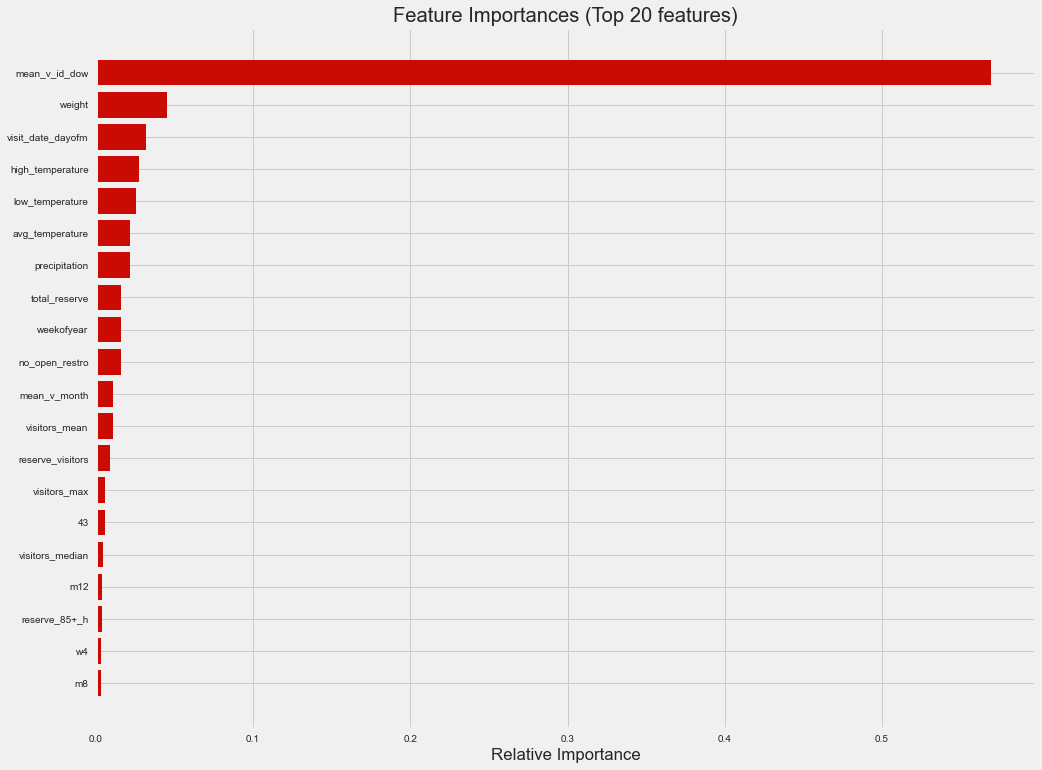

In [ ]:
# Plot the important features
features = train.columns
importances = model.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(15,12))
plt.title('Feature Importances (Top 20 features)')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 3. Feature Selection using Recursive Feature Elimination

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


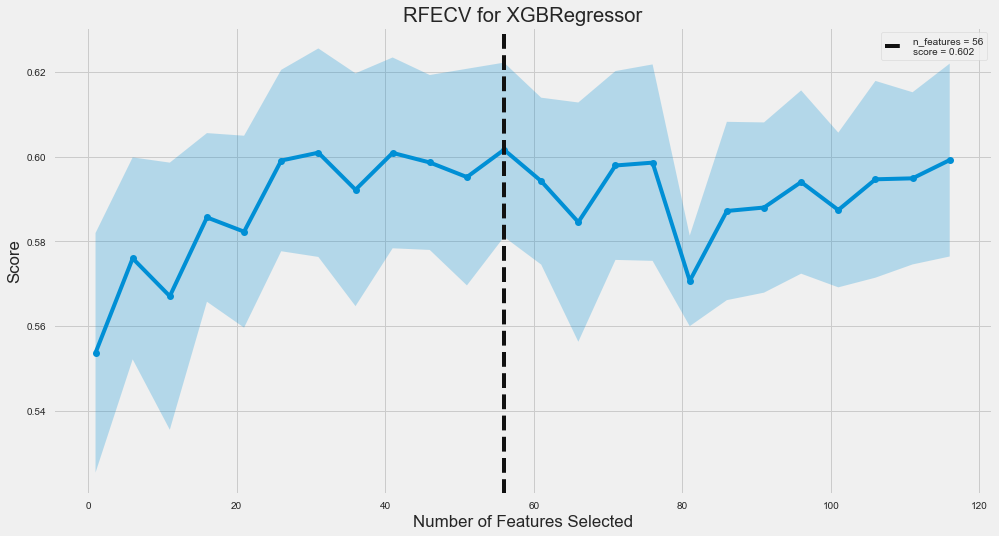

In [ ]:
# Set up XGBRegressor to instantiate RFECV
model = xgb.XGBRegressor(objective='reg:squarederror',
                        eval_metric='rmse',
                        tree_method='gpu_hist')

f, ax = plt.subplots(1,1, figsize=(15,8))

# Instantiate RFECV visualizer with a XGBRegressor with step=5
visualizer = RFECV(model, step=5, ax=ax)
visualizer.fit(X_train, y_train)
visualizer.show()

**From above plot we can observe number of optimal features = 56 with score=0.602.**

### Selecting optimal features using Recursive Feature Eliminator

In [ ]:
# Set up Recursive Feature Eliminator with n_features_to_select=61
rfe = RFE(estimator=model, n_features_to_select=61)
rfe.fit(X_train,y_train)
print("Selected Columns and their respective ranks:")
for i, j in enumerate(X_train.columns):
    if rfe.support_[i]:
        print('Column Name: {}, Rank: {}'.format(j, rfe.ranking_[i]))
    else:
        X_train.drop(columns=j, inplace=True)
        X_test.drop(columns=j, inplace=True)
        X_val.drop(columns=j, inplace=True)

Selected Columns and their respective ranks:-


Column Name: air_store_id, Rank: 1
Column Name: air_genre_name, Rank: 1
Column Name: holiday_eve, Rank: 1
Column Name: reserve_visitors, Rank: 1
Column Name: reserve_85+_h, Rank: 1
Column Name: visitors_mean, Rank: 1
Column Name: visitors_median, Rank: 1
Column Name: visitors_max, Rank: 1
Column Name: visit_date_month, Rank: 1
Column Name: visit_date_dayofw, Rank: 1
Column Name: visit_date_dayofm, Rank: 1
Column Name: weekofyear, Rank: 1
Column Name: total_reserve, Rank: 1
Column Name: mean_v_id_2017, Rank: 1
Column Name: median_vid_2017, Rank: 1
Column Name: mean_v_month, Rank: 1
Column Name: mean_v_dow_2017, Rank: 1
Column Name: mean_v_id, Rank: 1
Column Name: mean_v_id_dow, Rank: 1
Column Name: no_open_restro, Rank: 1
Column Name: holiday_flg, Rank: 1
Column Name: weight, Rank: 1
Column Name: hpg_store_id, Rank: 1
Column Name: precipitation, Rank: 1
Column Name: low_temperature, Rank: 1
Column Name: avg_temperature, Rank: 1
Column Name

In [ ]:
X_train.shape, y_train.shape

((235552, 61), (235552,))

In [ ]:
X_val.shape, y_val.shape

((16556, 61), (16556,))

In [ ]:
X_test.shape

(32019, 61)

In [ ]:
# Save processed data
X_train.to_csv(generated + 'X_train.csv',index=False)
X_val.to_csv(generated + 'X_val_after.csv',index=False)
X_test.to_csv(generated + 'X_test_after.csv',index=False)

# Modeling 

In [ ]:
# Read the dataframes again
X_train = pd.read_csv(generated + 'val_train.csv')
X_val = pd.read_csv(generated + 'val_test.csv')
y_train = np.load(generated + 'val_train_y.npy')
y_val = np.load(generated + 'val_test_y.npy')

train = pd.read_csv(generated + 'train.csv')
test = pd.read_csv(generated + 'test.csv')
y = np.load(generated + 'train_labels.npy')

y=y+1 # to get rid of log(0) error

### Scoring Function

In [ ]:
# Root Mean Squared logarithemic Error
def rmsle_score(y, y_pred):
    y = np.expm1(y)
    y_pred = np.expm1(y_pred)
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y + 1)).mean())

# Scoring function
score = make_scorer(rmsle_score, greater_is_better=False)

In [ ]:
# Root Mean Squared logarithemic Error
def rmsle(y_true,y_pred): 
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())

## 1. KNeighborsRegressor

In [ ]:
# Create a new KNeighborsRegressor
model1 = KNeighborsRegressor()

# Set up a grid for KNeighbors Regressor
p_grid = {'weights': ["uniform", "distance"],
          'n_neighbors': list(range(1,31))}

grid_knn = GridSearchCV(estimator=model1, 
                        param_grid=p_grid,
                        scoring=score,
                        cv=3,
                        n_jobs=-1)

# Fit the model to the data
grid_knn.fit(X_train, np.log1p(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 45.3min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 47.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=-1,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 20, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(rmsle_score, greater_is_better=False),
             verbose=10)

### Evaluation of the KNN Model

In [ ]:
# Validate the performance of model on the validation data
finalparam = grid_knn.best_params_
model1 = KNeighborsRegressor(n_neighbors=finalparam['n_neighbors'],
                              weights=finalparam['weights'])

model1.fit(X_train, np.log1p(y_train))

y_pred = model1.predict(X_val)
RMSLE = rmsle(y_true=y_val, y_pred=np.expm1(y_pred))
print('RMSLE for KNeighborsRegressor: ', RMSLE)

RMSLE for KNeighborsRegressor:- 0.5257479298169131


In [ ]:
# Predict the performance of model on the whole data
knn = KNeighborsRegressor(n_neighbors=finalparam['n_neighbors'],
                          weights=finalparam['weights'])
knn.fit(train, np.log1p(y))

y_test = knn.predict(test)
y_test = np.expm1(y_test) - 1 # to balance the 1, which is added before taking log

submission = pd.read_csv(output + 'sample_submission.csv')
submission.drop(columns='visitors', inplace=True)
submission['visitors'] = y_test
submission.to_csv(generated + 'knn_submission.csv', index=False)

## 2. DecisionTreeRegressor

In [ ]:
# Create a new DecisionTreeRegressor
model2 = DecisionTreeRegressor()

# Set up a grid for DecsisonTree Regressor
p_grid = {"max_depth": list(range(1,30)), 
          'min_samples_leaf': list(range(1,30))}

grid_dt = GridSearchCV(estimator=model2, 
                    param_grid=p_grid,
                    scoring=score,
                    cv=3,
                    n_jobs=-1)

# Fit the model to the data
grid_dt.fit(X_train, np.log1p(y_train))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  46 out of  48 | elapsed:  1.2min remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.2min finished


In [ ]:
# Print the best parameters
grid_dt.best_params_

{'max_depth': 10, 'min_samples_split': 500}

### Evaluation of the Decision Tree Model

In [ ]:
# Validate the performance of the model on the validation data
model2 = DecisionTreeRegressor(max_depth=10, min_samples_split=500)
model2.fit(X_train, np.log1p(y_train))

y_pred = model2.predict(X_val_after)
RMSLE = rmsle(y_true=y_val, y_pred=np.expm1(y_pred))
print('RMSLE for DecisionTreeRegressor: ', RMSLE)

RMSLE for DecisionTreeRegressor:- 0.4972822157330859


In [ ]:
# Predict the performance of the model on the whole data
dt = DecisionTreeRegressor(max_depth = 10, min_samples_split = 500)
dt.fit(train, np.log1p(y))

y_test = dt.predict(test)
y_test = np.expm1(y_test) - 1 # to balance the 1, which is added before taking log

submission = pd.read_csv(output + 'sample_submission.csv')
submission.drop(columns='visitors', inplace=True)
submission['visitors'] = y_test
submission.to_csv(generated + 'dt_submission.csv',index=False)

## 3. RandomForestRegressor

In [ ]:
# Create a new RandomForestRegressor
model3 = RandomForestRegressor()

# Set up a grid for RandomForest Regressor
p_grid = {'max_depth': [1, 5, 10, 50, 100, 500, 1000],
          'n_estimators': [5, 10, 50, 100, 250, 500]}

grid_rf = GridSearchCV(estimator=model3,
                     param_grid=p_grid,
                     scoring=score,
                     cv=3,
                     n_jobs=-1)

# Fit the model to the data
grid_rf.fit(X_train,np.log1p(y_train))

In [ ]:
# Print the best parameters
grid_rf.best_params_

{'max_depth': 50, 'n_estimators': 500}

### Evaluation of the Random Forest Model

In [ ]:
# Validate the performance on the validation data
model3 = RandomForestRegressor(max_depth=50, 
                               n_estimators=500)

model3.fit(X_train, np.log1p(y_train))

y_pred = rf.predict(X_val)
RMSLE = rmsle(y_true=y_val, y_pred=np.expm1(y_pred))
print('RMSLE of RandomForestRegressor: ', RMSLE)

Validation-RMSLE of RandomForestRegressor:- 0.4757688791817025


In [ ]:
# Predict the performance of the model on the whole data
rf = RandomForestRegressor(max_depth=50, n_estimators=500, n_jobs=-1)
rf.fit(train, np.log1p(y))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_test = rf.predict(test)
y_test = np.expm1(y_test) - 1 # to balance the 1, which is added before taking log

submission = pd.read_csv(output + 'sample_submission.csv')
submission.drop(columns='visitors',inplace=True)
submission['visitors'] = y_test
submission.to_csv(generated + 'rf_submission.csv',index=False)

## 4. XGBoost




In [ ]:
# Set up XGBoost optimized matrix
train_matrix = xgb.DMatrix(data=X_train, label=np.log1p(y_train))
val_matrix = xgb.DMatrix(data=X_val, label=np.log1p(y_val))

# Set up a grid for XGBoost
p_grid = {'learning_rate':[0.1,0.01,0.001],
          'min_child_weight':[0.8,0.9,1],
          'subsample':[0.5,0.6,0.7],
          'colsample_bytree':[0.3,0.4,0.5],
          'max_depth': [2,4,8]}

# Create a new XGBRegressor
model4 = xgb.XGBRegressor()

grid_xgb = GridSearchCV(estimator=model4,
                        param_grid=parameters,
                        scoring=score,
                        cv=3,
                        n_jobs=-1)

# Fit the model to the data
grid_xgb.fit(X=X_train, y=np.log1p(y_train))

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 4, 8]

In [ ]:
# Print the best parameters
grid_xgb.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 0.8,
 'subsample': 0.7}

### Evaluation of the XGBoost Model

In [ ]:
# Best Parameters
parameters = {'objective':'reg:squarederror',
              'eval_metric':'rmse',
              'learning_rate':0.01, 
              'min_child_weight':0.8,
              'subsample':0.7,
              'colsample_bytree':0.5,
              'max_depth': 8} 

# Optimized xgb.DMatrix
train_matrix = xgb.DMatrix(data=X_train, label=np.log1p(y_train))
val_matrix = xgb.DMatrix(data=X_val, label=np.log1p(y_val))

# Train the model on the validation data
model = xgb.train(params=parameters,
                  dtrain=train_matrix,
                  evals=[(train_matrix,'train'), (val_matrix,'test')])

[0]	train-rmse:2.41594	test-rmse:2.43355
[1]	train-rmse:2.39299	test-rmse:2.41036
[2]	train-rmse:2.37017	test-rmse:2.38717
[3]	train-rmse:2.34759	test-rmse:2.36417
[4]	train-rmse:2.32524	test-rmse:2.34147
[5]	train-rmse:2.30320	test-rmse:2.31924
[6]	train-rmse:2.28132	test-rmse:2.29702
[7]	train-rmse:2.25967	test-rmse:2.27497
[8]	train-rmse:2.23834	test-rmse:2.25338
[9]	train-rmse:2.21714	test-rmse:2.23174
[10]	train-rmse:2.19617	test-rmse:2.21028
[11]	train-rmse:2.17550	test-rmse:2.18932
[12]	train-rmse:2.15504	test-rmse:2.16860
[13]	train-rmse:2.13472	test-rmse:2.14798
[14]	train-rmse:2.11471	test-rmse:2.12779
[15]	train-rmse:2.09496	test-rmse:2.10782
[16]	train-rmse:2.07526	test-rmse:2.08778
[17]	train-rmse:2.05577	test-rmse:2.06790
[18]	train-rmse:2.03657	test-rmse:2.04836
[19]	train-rmse:2.01750	test-rmse:2.02894
[20]	train-rmse:1.99879	test-rmse:2.01008
[21]	train-rmse:1.98011	test-rmse:1.99119
[22]	train-rmse:1.96163	test-rmse:1.97234
[23]	train-rmse:1.94339	test-rmse:1.95387
[2

In [ ]:
RMSLE = RMSLE(y_val, np.expm1(model.predict(val_matrix)))
print('RMSLE of GBDT (XGBoost): ',RMSLE)

Validation-RMSLE of GBDT (XGBoost):- 0.45453431438864467


#### Predict the performance of XGBoost model on the whole data

In [ ]:
# Best parameters
parameters = {'objective':'reg:squarederror',
              'eval_metric':'rmse',
              'learning_rate':0.01, 
              'min_child_weight':0.8,
              'subsample':0.7,
              'colsample_bytree':0.3,
              'max_depth': 8, 
              'tree_method':'gpu_hist'}

# Optimized xgb.DMatrix
train_matrix = xgb.DMatrix(data=train, label=np.log1p(y))
test_matrix = xgb.DMatrix(data=test)

# Train the model in the whole dataset
XGB_model = xgb.train(params=parameters,
                 dtrain=train_matrix)

In [ ]:
y_test = XGB_model.predict(test_matrix)
y_test = np.expm1(y_test) - 1 # to balance the 1, which is added before taking log

submission = pd.read_csv(output + 'sample_submission.csv')
submission.drop(columns='visitors', inplace=True)
submission['visitors'] = y_test
submission.to_csv(generated + 'xgb_submission.csv',index=False)

## 5. LSTM

In [ ]:
# Scale the input data
std = StandardScaler() 

X_train_std = std.fit_transform(X_train.values)
X_val_std = std.fit_transform(X_val.values)

std.fit(np.r_[X_train.values, X_val.values])
X_test_std = std.transform(X_test.values)

# Reshape input
X_train_lstm = X_train_std.reshape(X_train_std.shape[0], 1, X_train_std.shape[1])
X_val_lstm = X_val_std.reshape(X_val_std.shape[0], 1, X_val_std.shape[1])
X_test_lstm = X_test_std.reshape(X_test_std.shape[0], 1, X_test_std.shape[1])

print("X_train: ", X_train_lstm.shape)
print("X_val: ", X_val_lstm.shape)
print("X_test: ", X_test_lstm.shape)

x_train:  (236338, 1, 125)
x_val:  (15770, 1, 125)
x_test:  (32019, 1, 125)


In [ ]:
# RMSLE Calculation function
def lstm_rmsle(y_true, y_pred):
    
    # Get exp of log predictions
    y_pred = tf.math.expm1(y_pred)
    y_true = tf.math.expm1(y_true)

    # Calculate rmsle
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

lstm_rmsle_scorer = make_scorer(score_func=lstm_rmsle, greater_is_better=False)

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(units=30, activation='relu', return_sequences=True))
model.add(Dense(units=1, activation='relu'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=lstm_rmsle_scorer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             35200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 30)             9720      
_________________________________________________________________
dense (Dense)                (None, 1, 1)              31        
Total params: 44,951
Trainable params: 44,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_dl_rmsle', patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_dl_rmsle', patience=5)

epochs = 15
batch_size = 64

model.fit(X_train_lstm, y_train.values.reshape(-1),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=(X_val_lstm, y_val.values.reshape(-1)), 
        callbacks=[reduce_lr, early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/15
3693/3693 [==============================] - 109s 29ms/step - loss: 0.3784 - dl_rmsle: 0.5558 - val_loss: 0.2671 - val_dl_rmsle: 0.5052
Epoch 2/15
3693/3693 [==============================] - 107s 29ms/step - loss: 0.2457 - dl_rmsle: 0.4919 - val_loss: 0.2691 - val_dl_rmsle: 0.5069
Epoch 3/15
3693/3693 [==============================] - 108s 29ms/step - loss: 0.2393 - dl_rmsle: 0.4855 - val_loss: 0.2600 - val_dl_rmsle: 0.4986
Epoch 4/15
3693/3693 [==============================] - 108s 29ms/step - loss: 0.2350 - dl_rmsle: 0.4812 - val_loss: 0.2623 - val_dl_rmsle: 0.5015
Epoch 5/15
3693/3693 [==============================] - 103s 28ms/step - loss: 0.2320 - dl_rmsle: 0.4780 - val_loss: 0.2581 - val_dl_rmsle: 0.4973
Epoch 6/15
3693/3693 [==============================] - 103s 28ms/step - loss: 0.2293 - dl_rmsle: 0.4753 - val_loss: 0.2616 - val_dl_rmsle: 0.4999
Epoch 7/15
3693/3693 [==============================] - 102s 28ms/step - loss: 0.2273 - dl_rmsle: 0.4731 - val_loss: 0

In [ ]:
# Validate the model on the validation data
y_test = model.predict(X_val_lstm)
lstm_rmsle_score = lstm_rmsle(y_val.values.reshape(-1), y_test)

print('Best Train RMSLE: ', lstm_rmsle_score)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Best Train RMSLE 1.072922885336004


In [ ]:
# Make predictions on the testing data
lstm_predictions = model.predict(X_test_lstm)

result = []
for pred in lstm_predictions:
    result.append(pred[0][0])

submission = pd.read_csv(output + 'sample_submission.csv')
submission.drop(columns='visitors', inplace=True)
submission['visitors'] = np.expm1(result)

submission.to_csv(generated + 'lstm_submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


## Observations

### Validation Root Mean Square logarithemic Error of each model

In [ ]:
df = pd.DataFrame({"Validation RMSLE":[0.5257,0.4972,0.4757,0.4545,1.07]})
df.index = ['KNeighborsRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor (GBDT)', 'LSTM (Neural Network)']
df

,Validation RMSLE
KNeighborsRegressor,0.5257
DecisionTreeRegressor,0.4972
RandomForestRegressor,0.4757
XGBRegressor (GBDT),0.4545
LSTM (Neural Network),1.0700


**The best RMSLE we got is 0.45 from XGBRegressor (GBDT) and hence XGBoost is the best model.**

## Kaggle Submission:

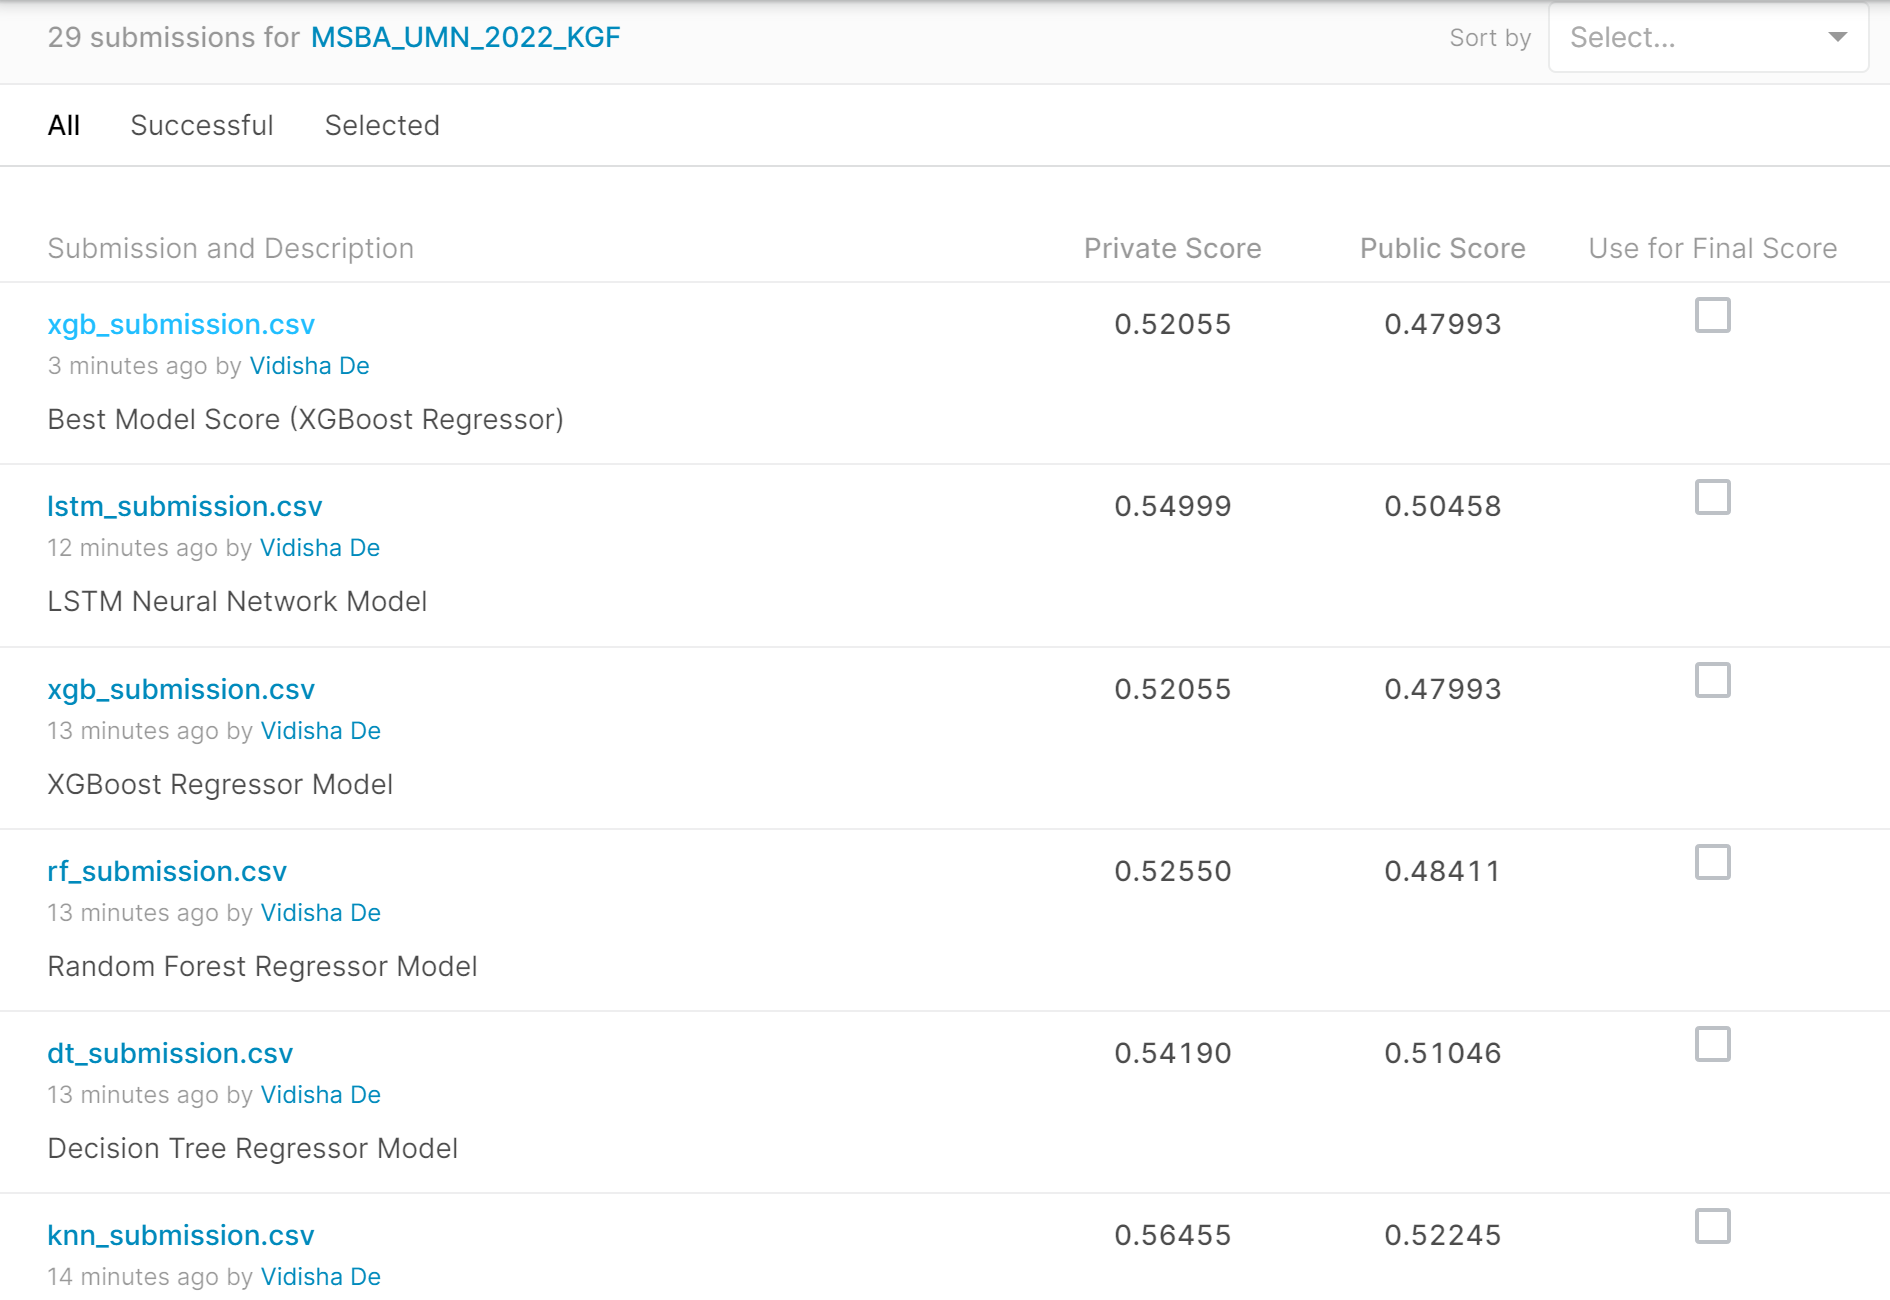

In [ ]:
df = pd.DataFrame({"Public Score":[0.52245,0.51046,0.48411,0.47993,0.50458]})
df.index = ['KNeighborsRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor (GBDT)', 'LSTM (Neural Network)']
df

,Public Score
KNeighborsRegressor,0.52245
DecisionTreeRegressor,0.51046
RandomForestRegressor,0.48411
XGBRegressor (GBDT),0.47993
LSTM (Neural Network),0.50458


**For Kaggle submission, The best RMSLE is from XGBRegressor and hence XGBRegressor is the best model for this problem.**
